In [ ]:
#default_exp bbox_east_inference

In [ ]:
#export
from ocr.bbox_east_training import *
from ocr.bbox_east_training import east_config
from ocr.bbox_east_training import create_grid
from ocr.core import load_inference, plot
from fastai import *
from fastai.vision import *
import numpy as np
import cv2

In [ ]:
east_config.input_shape

(1024, 384)

In [ ]:
#export
class TextBBoxPredictor:
    def __init__(self, model_name='east_bbox', use_gpu=False, trained_input_shape=east_config.input_shape, out_shape=east_config.out_shape):
        '''
        @param: str       :name of model in ../models dir
        @param: bool      :use gpu? (model ~800mb)
        @param: np.arr[2] :[height, width] of image (when training)
        @param: np.arr[2] :[h_in/h_out, w_in/w_out] (how much output is smaller then input)
        '''
        self.model_name, self.use_gpu = model_name, use_gpu
        if self.use_gpu: defaults.device = torch.device('cuda')
        else: defaults.device = torch.device('cpu')
        self.learner = load_inference(model_name)
        self.train_shape = tensor(trained_input_shape)
        self.out_shape = tensor(out_shape)
        self.anchors = create_grid(tuple(self.train_shape//self.out_shape)).view(-1,4)
        
    def image2bboxes(self, image, shape='train', offset=0, detect_thresh=0.8, nms_threshold=0.2):
        ''' 
        @param: torch.arr [h,w,3] :(make sure its in RGB not BGR! and pixel range is [0-255])
        @param: np.arr [2]        :[height, width] of nn input (if None leaves the same, if 'train' leaves self.train_shape)
        @param: int               :make each box bigger by `offset` amount
        @param: float             :bboxes are considered found only if p(bbox) > this
        @param: float             :if IoU(bbox1,bbox2)>this, then it is same bbox
        @return torch.arr[N,4]    :list of [top,left,btm,right] coords
        '''
        # preprocess image
        if image.size(2) == 3: image = image.permute(2,0,1) # [3,h,w]
        im_orig = image
        c, h_orig, w_orig = image.shape
        if shape is not None:
            shape = tensor(shape) if shape != 'train' else self.train_shape
            if len(image.shape) == 3: image = image[None]
            image = F.interpolate(image.type(torch.float32), size=tuple(shape), mode='bilinear', align_corners=True).squeeze() # [3,h,w]
        # get ready for learner
        image = Image(image.float() / 255.)
        batch = self.learner.data.one_item(image)
        # predict w/ model
        score, geo = self.learner.model.eval()(batch[0]) # [1,1,H,W], [1,4,H,W]
        bbox_pred = geo[0].permute(1,2,0).view(-1,4)
        y_pred = score[0].view(-1,1)
        # preprocess bboxes
        anchors = self.anchors
        if shape is None: shape = (h_orig, w_orig)
        if (shape != self.train_shape).all(): anchors = create_grid(tuple(tensor(shape)//self.out_shape)).view(-1,4)
        bbox_pred = target_to_bbox(bbox_pred, self.anchors.to(y_pred.device))
        # filter w/ small probs
        detect_mask = y_pred.squeeze() > detect_thresh # [H x W]
        if detect_mask.sum() == 0: pass
        # non maximum suppression
        t = bbox_pred[detect_mask]
        keep_idxes = nms(t, y_pred[detect_mask].view(-1), threshold=nms_threshold)
        bboxes = to_np(t[keep_idxes]) # [N,4]
        # resize bboxes
        resized_bboxes = []
        for t,l,b,r in bboxes:
            # denormalize
            t,b = tuple(map(lambda x: int((x+1)/2*h_orig), [t,b]))
            l,r = tuple(map(lambda x: int((x+1)/2*w_orig), [l,r]))
            # offset
            t -= offset
            l -= offset
            b += offset
            r += offset
            # fit into image
            t,l = tuple(map(lambda x: max(x, 0), [t,l]))
            b = min(b, h_orig)
            r = min(r, w_orig)
            resized_bboxes.append([t,l,b,r])
        return tensor(resized_bboxes).long()

In [ ]:
# old
def show_bboxes_on_image(im, bboxes):
    # [h,w,3]
    # [N,4]
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    imageBB = ImageBBox.create(*im.shape[:2], tensor(bboxes), scale=True)
    return Image(tensor(im).permute(2,0,1).float() / 255.).show(ax=ax, y=imageBB)

In [ ]:
#export
def bboxes_on_image(im, bboxes): # [h,w,3], [N,4]
    im = im.copy()
    for bb in bboxes: # [4]
        im = cv2.rectangle(im, (bb[1],bb[0]), (bb[3],bb[2]), (255,255,0), thickness=10) 
    return im

def show_bboxes_on_image(im, bboxes, **kwargs):
    return plot(bboxes_on_image(im, bboxes), **kwargs)

In [ ]:
im = cv2.imread('../test_data/cekis_cropped.jpg')

In [ ]:
t = TextBBoxPredictor(model_name='east_bbox_10x3', use_gpu=True)
bboxes = t.image2bboxes(tensor(im))

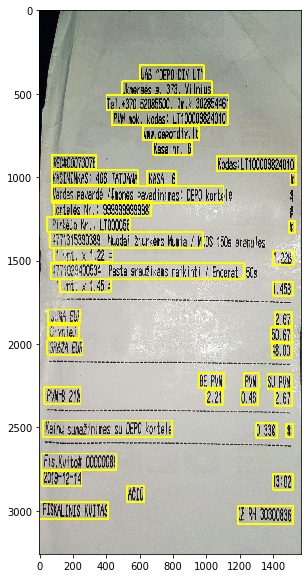

In [ ]:
show_bboxes_on_image(im, bboxes, figsize=(10,10))

## Times

In [ ]:
from ocr.bbox_east_training import *
predictor_gpu = TextBBoxPredictor(model_name='east_bbox', use_gpu=True)
predictor_cpu = TextBBoxPredictor(model_name='east_bbox', use_gpu=False)

In [ ]:
%%timeit
_ = predictor_cpu.image2bboxes(tensor(im), shape='train')

390 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_ = predictor_cpu.image2bboxes(tensor(im), shape=(1024,1024))

396 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
_ = predictor_gpu.image2bboxes(tensor(im), shape='train')

60.8 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
_ = predictor_gpu.image2bboxes(tensor(im), shape=(1024,1024))

73.7 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
